<a href="https://colab.research.google.com/github/chungntu/1DCNN-LSTM-ResNet/blob/main/Problem_9a_Bernoulli_beam_with_spring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Displacements
  1   0.000000e+00
  2   0.000000e+00
  3  -4.321543e+05
  4  -1.574387e+05
  5  -6.174784e+05
  6   7.402408e+04
  7  -3.749906e+02
  8   2.499438e+05
  9   0.000000e+00


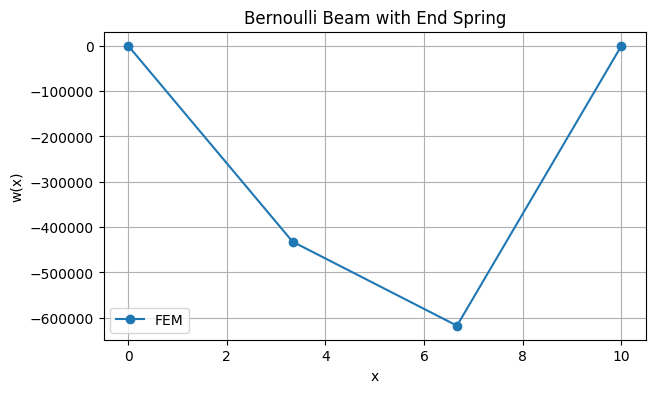


Exact solution (Bathe):
[-7.01816711e+05 -8.57907556e+05 -3.94727493e+02]


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Bernoulli Beam + Spring FEM (problem9a.m)
# MATLAB -> Python (Google Colab)
# ============================================================

def solution(GDof, prescribedDof, K, F):
    prescribed = np.array([d-1 for d in prescribedDof], dtype=int)  # 0-based
    all_dofs = np.arange(GDof)
    free = np.setdiff1d(all_dofs, prescribed)

    U = np.zeros(GDof)

    K_ff = K[np.ix_(free, free)]
    F_f  = F[free]

    U[free] = np.linalg.solve(K_ff, F_f)
    return U


def formStiffnessBernoulliBeam(GDof, numberElements, elementNodes, numberNodes, xx, EI, P):
    K = np.zeros((GDof, GDof))
    F = np.zeros(GDof)

    for e in range(numberElements):
        i, j = elementNodes[e]
        i -= 1; j -= 1  # to 0-based

        elementDof = np.array([
            2*i, 2*i+1,
            2*j, 2*j+1
        ])

        LE = xx[j] - xx[i]

        k1 = (EI / LE**3) * np.array([
            [ 12,   6*LE,  -12,   6*LE],
            [ 6*LE, 4*LE**2, -6*LE, 2*LE**2],
            [-12,  -6*LE,   12,  -6*LE],
            [ 6*LE, 2*LE**2, -6*LE, 4*LE**2]
        ])

        f1 = np.array([
            P*LE/2,
            P*LE**2/12,
            P*LE/2,
            -P*LE**2/12
        ])

        K[np.ix_(elementDof, elementDof)] += k1
        F[elementDof] += f1

    return K, F


# ============================================================
# Input (same as MATLAB)
# ============================================================

E = 1e6
L = 10.0
t = L / 1000
I = t**3 / 12
EI = E * I

numberElements = 3
nodeCoordinates = np.linspace(0, L, numberElements + 1)
xx = nodeCoordinates
numberNodes = len(nodeCoordinates)

elementNodes = np.column_stack([
    np.arange(1, numberElements + 1),
    np.arange(2, numberElements + 2)
])

P = -1000.0   # distributed load
k = 10.0      # spring stiffness

GDof = 2 * numberNodes

# ============================================================
# Beam stiffness
# ============================================================

K_beam, F_beam = formStiffnessBernoulliBeam(
    GDof, numberElements, elementNodes, numberNodes, xx, EI, P
)

# ============================================================
# Add spring (extra DOF)
# ============================================================

K = np.zeros((GDof+1, GDof+1))
F = np.zeros(GDof+1)

K[:GDof, :GDof] = K_beam
F[:GDof] = F_beam

# Spring between DOF (GDof-1) and new DOF (GDof)
K[GDof-2:GDof+1:2, GDof-2:GDof+1:2] += k * np.array([[ 1, -1],
                                                      [-1,  1]])

# ============================================================
# Boundary conditions
# ============================================================

# fixed at x=0
fixedNodeU = [1]  # w(0)
fixedNodeV = [2]  # theta(0)

# spring bottom fixed
prescribedDof = fixedNodeU + fixedNodeV + [GDof+1]

# ============================================================
# Solution
# ============================================================

U = solution(GDof+1, prescribedDof, K, F)

# ============================================================
# Output
# ============================================================

print("Displacements")
for i, ui in enumerate(U, start=1):
    print(f"{i:3d}  {ui: .6e}")

# ============================================================
# Plot deflection
# ============================================================

w = U[0:2*numberNodes:2]

plt.figure(figsize=(7,4))
plt.plot(nodeCoordinates, w, 'o-', label='FEM')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('w(x)')
plt.title('Bernoulli Beam with End Spring')
plt.legend()
plt.show()

# ============================================================
# Bathe exact solution (as in MATLAB)
# ============================================================

load = np.array([L*P/3, L*P/3, L*P/6])
K_exact = (E*I/L**3) * np.array([
    [189, -108,  27],
    [-108, 135, -54],
    [ 27, -54, 27 + k*L**3/(E*I)]
])

X = np.linalg.solve(K_exact, load)

print("\nExact solution (Bathe):")
print(X)
